# Step 3: Asigning urban contexts to inscriptions

*AIM*: Assign each inscription an urban context, depending on the available spatio-temporal data.

References: 

1) `Hanson J. W., An urban geography of the Roman world, 100 BC to AD 300. Oxford: Archaeopress; 2016. http://oxrep.classics.ox.ac.uk/oxrep/docs/Hanson2016/Hanson2016_Cities_OxREP.csv`
2) `Hanson J. W, Ortman S. G., A systematic method for estimating the populations of Greek and Roman settlements. J Roman Archaeol. 2017;30: 301–324.`


This script was originally published by `Kaše V, Heřmánková P, Sobotková A (2022) Division of labor, specialization and diversity in the ancient Roman cities: A quantitative approach to Latin epigraphy. PLoS ONE 17(6): e0269869. https://doi.org/10.1371/journal.pone.0269869` under a CC BY-SA 4.0 International License. 

https://github.com/sdam-au/social_diversity

The *Past Social Networks Project* adapted the script to fit the needs of the project research agenda.

## Data:

**IN**:

1) Inscriptions `LIST_occups.parquet`

2) Roman cities `roman_cities_pop.parquet`

3) Roman provinces `pleiades_regions.geojson`

**OUT**: 

1) Inscriptions with occupational data and urban contexts `LIST_contexts.parquet`

# Requirements

In [1]:
import re
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from pyproj import Geod
from shapely.geometry import LineString

import seaborn as sns
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library
import sddk
import os


In [3]:
# global parameters for plots
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    fig.savefig("../../figures/" + fig_name + ".eps") # saves locally
    fig.savefig("../../figures/" + fig_name + ".png")
    s.write_file(PSNP_figs + fig_name + ".eps", fig) # saves to Sciencedata 
    s.write_file(PSNP_figs + fig_name + ".png", fig)

## Import the epigraphic dataset

In [5]:
# find local version of the input dataset
local_paths = !find ~/Github -name "LIST_occupsorgs.parquet"
print(local_paths)

['/home/au648560/Github/latin_socdiv/data/large_data/LIST_occupsorgs.parquet']


In [7]:
# read LIST dataset from zenodo or locally, if already available on your computer. 
###   WARNING - if there is no local copy this will load the raw data from Zenodo without any occupational 
#and organizational data, generated in the script no. 2

try:
    LIST = gpd.read_parquet(local_paths[0])
    print("local copy found and loaded")
except:# !!! use carefully - takes time
    q = input("local file not found, try another put, or input 'y' for download")
    if q == "y":
        LIST = gpd.read_file("https://zenodo.org/record/8431323/files/LIST_v1-0.geojson?download=1", driver="geoJSON")
        print("file downloaded from zenodo")
        LIST.to_parquet("../../data/large_data/LISTg.parquet")

local copy found and loaded


In [8]:
# making sure the data exists and loaded properly, printing out all the attribute names
print(LIST.columns.tolist())

['LIST-ID', 'EDCS-ID', 'EDH-ID', 'trismegistos_uri', 'pleiades_id', 'transcription', 'inscription', 'clean_text_conservative', 'clean_text_interpretive_sentence', 'clean_text_interpretive_word', 'clean_text_interpretive_word_EDCS', 'diplomatic_text', 'province', 'place', 'inscr_type', 'status_notation', 'inscr_process', 'status', 'partner_link', 'last_update', 'letter_size', 'type_of_inscription', 'work_status', 'year_of_find', 'present_location', 'text_edition', 'support_objecttype', 'support_material', 'support_decoration', 'keywords_term', 'people', 'type_of_inscription_clean', 'type_of_inscription_certainty', 'height_cm', 'width_cm', 'depth_cm', 'material_clean', 'type_of_monument_clean', 'type_of_monument_certainty', 'province_label_clean', 'province_label_certainty', 'country_clean', 'country_certainty', 'findspot_ancient_clean', 'findspot_ancient_certainty', 'modern_region_clean', 'modern_region_certainty', 'findspot_modern_clean', 'findspot_modern_certainty', 'findspot_clean', 


## Population estimates 

In [9]:
#roman_cities = gpd.read_file("../../data/roman_cities_pop.geojson")
roman_cities = gpd.read_parquet("../../data/roman_cities_pop.parquet")
pleiades_regions = gpd.read_file("../../data/pleiades_regions.geojson")


In [10]:
# total population estimate based on calculations from Hanson and Ortman 2017
roman_cities["pop_est"].sum()

10214337.0

In [11]:
# how many cities have the population estimate larger than 30,000
(roman_cities["pop_est"] >= 30000).sum()

68

In [12]:
# printing attribute names
print(roman_cities.columns.tolist())

['Primary Key', 'Ancient Toponym', 'Modern Toponym', 'Province', 'Country', 'Barrington Atlas Rank', 'Barrington Atlas Reference', 'Start Date', 'End Date', 'Select Bibliography', 'Area', 'Estimate Basis', 'Civic Status', 'Structure', 'num_of_structures', 'geometry', 'ID', 'level_0', 'Unnamed: 0_y', 'index', 'pop_sample', 'pop_est', 'pop_diff', 'western_province']


# Distance to settlement based on the size of its population estimate

In [ ]:
# defines the size of urban context based on the population estimates from Hanson and Ortman 2017

masks_dict = {}
masks_dict["large"] = roman_cities["pop_est"] >= 30000
masks_dict["medium"] = (roman_cities["pop_est"] >= 5000) & (roman_cities["pop_est"] < 30000)
masks_dict["small"] = small_cities_mask = roman_cities["pop_est"] < 5000

In [32]:
# overview: how many cities per rank and their population estimates

for mask in masks_dict.keys():
    print(mask, len(roman_cities[masks_dict[mask]]), roman_cities[masks_dict[mask]]["pop_est"].sum())

large 68 4641352.0
medium 337 4005250.0
small 983 1567735.0


In [33]:
# custom function assigning each inscription the nearest city

geod = Geod(ellps="WGS84")
def get_dist_m(inscr_geo, city_geo):
    line_string = LineString([inscr_geo, city_geo])
    return np.round(geod.geometry_length(line_string), 2)

def ckdnearest(inscriptions, cities, city_type):
    cities = cities[masks_dict[city_type]]
    cities = cities[['ID', 'geometry']]
    cities.rename(columns={"ID" : city_type + "_city_ID"}, inplace=True)
    insr_geometries = np.array(list(inscriptions.geometry.apply(lambda x: (x.x, x.y))))
    cities_geometries = np.array(list(cities.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(cities_geometries)
    dist, idx = btree.query(insr_geometries, k=1)
    nearest_cities_df = cities.iloc[idx].rename(columns={"geometry": city_type +"_city_geo"}).reset_index(drop=True)
    nearest_cities_df[city_type + "_city_geo"] = [[geom.x, geom.y] for geom in nearest_cities_df[city_type + "_city_geo"]]

    merge_gdf = pd.concat(
        [
            inscriptions.reset_index(drop=True),
            nearest_cities_df,
            pd.Series(dist, name=city_type + "_city_dist")
        ],
        axis=1)
    merge_gdf[city_type + "_city_dist"] = merge_gdf.apply(lambda row: get_dist_m(row.geometry, row[city_type + "_city_geo"]), axis=1)
    return merge_gdf

In [34]:
LIST.head(5)

,LIST-ID,EDCS-ID,EDH-ID,trismegistos_uri,pleiades_id,transcription,inscription,clean_text_conservative,clean_text_interpretive_sentence,clean_text_interpretive_word,clean_text_interpretive_word_EDCS,diplomatic_text,province,place,inscr_type,status_notation,inscr_process,status,partner_link,last_update,letter_size,type_of_inscription,work_status,year_of_find,present_location,text_edition,support_objecttype,support_material,support_decoration,keywords_term,people,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,language_EDCS,raw_dating,not_after,not_before,Longitude,Latitude,is_geotemporal,geometry,is_within_RE,urban_context,urban_context_city,urban_context_pop_est,type_of_inscription_auto,type_of_inscription_auto_prob,occups,occups_N,organizations,organizations_N,is_western
445463,445464,EDCS-24900077,HD056163,https://www.trismegistos.org/text/177366,570485,Q(uinto) Caecilio C(ai) f(ilio) Metelo / imper...,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Q Caecilio C f Metelo imperatori Italici quei ...,Quinto Caecilio Cai filio Metelo imperatori It...,Quinto Caecilio Cai filio Metelo imperatori It...,Quinto Caecilio Cai filio Metello imperatori I...,Q CAECILIO C F METELO / IMPERATORI ITALICI / Q...,Achaia,Agia Triada / Merbaka / Midea,tituli honorarii,"officium/professio, ordo senatorius, tria nomi...",None,officium/professio; ordo senatorius; tituli ...,http://db.edcs.eu/epigr/partner.php?s_language...,2011-11-11,None,honorific inscription,no image,NaN,None,\n Quinto Caecilio Cai filio Metelo imperatori...,None,None,1000,69,"[{'age: days': None, 'age: hours': None, 'age:...",honorific inscription,False,NaN,NaN,NaN,NULL,NULL,False,Achaia,False,Greece,False,Midea,False,Pelopónissos,False,Midhéa,False,NULL,False,None,-68 to -68,-68.0,-68.0,22.841200,37.649800,True,POINT (22.841 37.650),True,rural,None,NaN,honorific inscription,1.0,[],0,[],0,False
445464,445465,EDCS-03700724,HD052964,https://www.trismegistos.org/text/121715,531064,Fortissimo et piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Fortissimo et piissimo Caesari domino nostro G...,Fortissimo et Piissimo Caesari domino nostro G...,FORTISSIMO ET PIIS / SIMO CAESARI D N / GAL VA...,Achaia,Agios Athanasios / Photike,tituli honorarii,"Augusti/Augustae, ordo equester, tria nomina",litterae erasae,Augusti/Augustae; litterae erasae; ordo eque...,http://db.edcs.eu/epigr/partner.php?s_language...,2014-09-16,3-5.3 cm,honorific inscription,checked with photo,NaN,Fragma Kalama,\n Fortissimo et piissimo Caesari domino nostr...,57,None,1000,69,"[{'age: days': None, 'age: hours': None, 'age:...",honorific inscription,False,99.0,67.0,67.0,NULL,statue base,False,Epirus,False,Greece,False,Photike,False,Ípeiros,False,Paramythía,False,{Agios Athanasios},False,None,309 to 313,313.0,309.0,20.766800,39.451200,True,POINT (20.767 39.451),True,rural,None,NaN,honorific inscription,1.0,[],0,[],0,False
445465,445466,EDCS-13800065,HD017714,https://www.trismegistos.org/text/177100,570049,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei quei Aegei negotiantur P Rutilium P f...,Italicei quei Aegei negotiantur Publium Rutili...,Italicei quei Aegei negotiantur Publium Rutili...,Italicei quei Aegei negotiantur Publium Rutili...,ITALICEI / QVEI AEGEI NEGOTIANTVR / P RVTILIVM...,Achaia,Aigio / Egio / Aiyion / Aegeum,tituli honorarii,"officium/professio, ordo senatorius, tria nomi...",None,officium/professio; ordo senatorius; tituli ...,http://db.edcs.eu/epigr/partne

In [35]:
# filter dataset to contain only inscriptions with geometry 

LISTgeo = LIST[~LIST["geometry"].is_empty]

In [36]:
# how big is the geolocated dataset
len(LISTgeo)

511973

In [37]:
%%time

# computes the nearest urban context for a given inscription (point to point)

LISTgeo = ckdnearest(LISTgeo, roman_cities, "large")
LISTgeo = ckdnearest(LISTgeo, roman_cities, "medium")
LISTgeo = ckdnearest(LISTgeo, roman_cities, "small")

CPU times: user 1min 29s, sys: 2.04 s, total: 1min 31s
Wall time: 1min 31s


In [38]:
LISTgeo.head(3)

,LIST-ID,EDCS-ID,EDH-ID,trismegistos_uri,pleiades_id,transcription,inscription,clean_text_conservative,clean_text_interpretive_sentence,clean_text_interpretive_word,clean_text_interpretive_word_EDCS,diplomatic_text,province,place,inscr_type,status_notation,inscr_process,status,partner_link,last_update,letter_size,type_of_inscription,work_status,year_of_find,present_location,text_edition,support_objecttype,support_material,support_decoration,keywords_term,people,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,language_EDCS,raw_dating,not_after,not_before,Longitude,Latitude,is_geotemporal,geometry,is_within_RE,urban_context,urban_context_city,urban_context_pop_est,type_of_inscription_auto,type_of_inscription_auto_prob,occups,occups_N,organizations,organizations_N,is_western,large_city_ID,large_city_geo,large_city_dist,medium_city_ID,medium_city_geo,medium_city_dist,small_city_ID,small_city_geo,small_city_dist
0,445464,EDCS-24900077,HD056163,https://www.trismegistos.org/text/177366,570485,Q(uinto) Caecilio C(ai) f(ilio) Metelo / imper...,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Q Caecilio C f Metelo imperatori Italici quei ...,Quinto Caecilio Cai filio Metelo imperatori It...,Quinto Caecilio Cai filio Metelo imperatori It...,Quinto Caecilio Cai filio Metello imperatori I...,Q CAECILIO C F METELO / IMPERATORI ITALICI / Q...,Achaia,Agia Triada / Merbaka / Midea,tituli honorarii,"officium/professio, ordo senatorius, tria nomi...",None,officium/professio; ordo senatorius; tituli ...,http://db.edcs.eu/epigr/partner.php?s_language...,2011-11-11,None,honorific inscription,no image,NaN,None,\n Quinto Caecilio Cai filio Metelo imperatori...,None,None,1000,69,"[{'age: days': None, 'age: hours': None, 'age:...",honorific inscription,False,NaN,NaN,NaN,NULL,NULL,False,Achaia,False,Greece,False,Midea,False,Pelopónissos,False,Midhéa,False,NULL,False,None,-68 to -68,-68.0,-68.0,22.8412,37.6498,True,POINT (22.841 37.650),True,rural,None,NaN,honorific inscription,1.0,[],0,[],0,False,13,"[22.719769, 37.631278]",10912.81,85,"[22.641069, 37.831664]",26806.86,36,"[23.132244, 37.626573]",25817.21
1,445465,EDCS-03700724,HD052964,https://www.trismegistos.org/text/121715,531064,Fortissimo et piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Fortissimo et piissimo Caesari domino nostro G...,Fortissimo et Piissimo Caesari domino nostro G...,FORTISSIMO ET PIIS / SIMO CAESARI D N / GAL VA...,Achaia,Agios Athanasios / Photike,tituli honorarii,"Augusti/Augustae, ordo equester, tria nomina",litterae erasae,Augusti/Augustae; litterae erasae; ordo eque...,http://db.edcs.eu/epigr/partner.php?s_language...,2014-09-16,3-5.3 cm,honorific inscription,checked with photo,NaN,Fragma Kalama,\n Fortissimo et piissimo Caesari domino nostr...,57,None,1000,69,"[{'age: days': None, 'age: hours': None, 'age:...",honorific inscription,False,99.0,67.0,67.0,NULL,statue base,False,Epirus,False,Greece,False,Photike,False,Ípeiros,False,Paramythía,False,{Agios Athanasios},False,None,309 to 313,313.0,309.0,20.7668,39.4512,True,POINT (20.767 39.451),True,rural,None,NaN,honorific inscription,1.0,[],0,[],0,False,65,"[20.733395, 39.026505]",47237.78,7,"[20.987, 39.158]",37687.28,31,"[20.787767, 39.546432]",10725.84
2,445466,EDCS-13800065,HD017714,https://www.trismegistos.org/text/177100,570049,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei quei Aegei negotiantur P Rutilium P f...,Italicei quei Aegei negotiantur Publium Rutili...,Italicei q

TypeError: kdeplot() got multiple values for argument 'data'

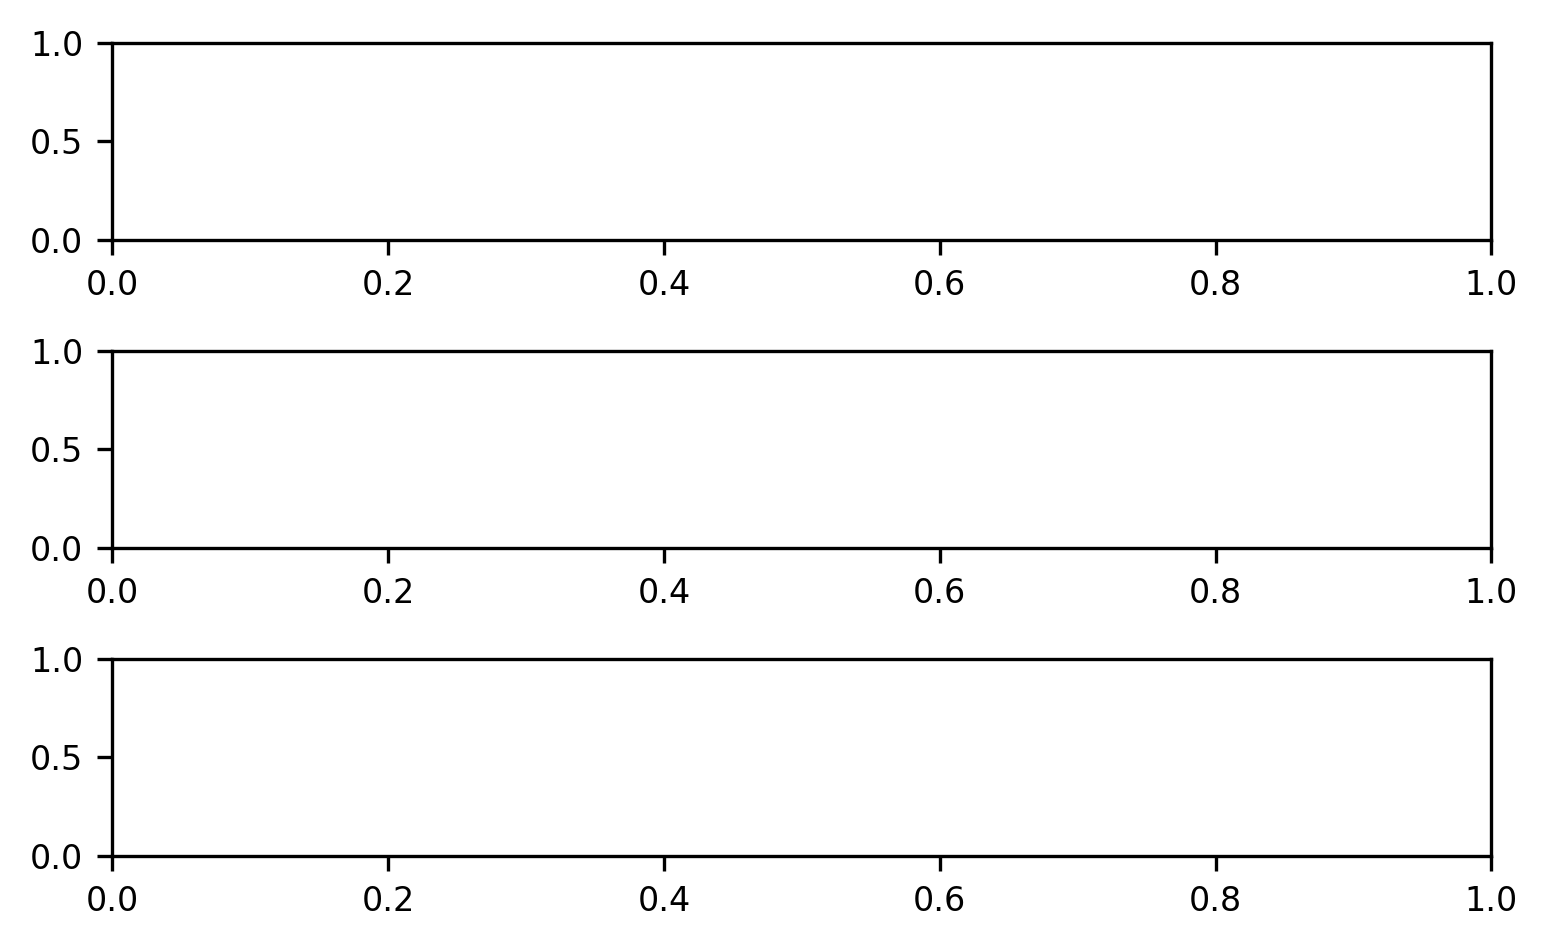

In [42]:
# plot the distance to nearest city for a given urban context type

fig, [ax1, ax2, ax3]=plt.subplots(3, 1, figsize=(5.2, 3.2), tight_layout=True)

for ax, label, color in zip([ax1, ax2, ax3], ["large", "medium", "small"], ["blue", "green", "red"]):
    sns.kdeplot(label + "_city_dist", color=color, data=LISTgeo, ax=ax)
    ax.set_title(label)
    ax.set_xlim(0, 1000000)
    ax.set_xticks([0, 250000, 500000, 750000, 1000000])
    ax.set_xticklabels(["0", "250km", "500km", "750km", "1000km"])
    ax.set_yticklabels([])
    if label in ["large", "medium"]:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    else:
        ax.set_xlabel("LIST: distance to nearest city for a given urban context type")

In [ ]:
save_figure(fig, "dist_to_nearest_by_type")

## Spatial clustering of inscriptions around urban contexts

In [43]:
# Bodel claims that Roman inscriptions are dispersed over an area of about 30 square km. Bodel 2001?
np.sqrt(30 / np.pi)

3.0901936161855166

In [44]:
# custom function creating a 5km buffer zone around each settlement/urban context


def get_urban_context(row):
    buffer=5000
    urban_context = "rural"
    if row["large_city_dist"] <= buffer:
        urban_context = "large"
    else:
        if row["medium_city_dist"] <= buffer:
            urban_context = "medium"
        else:
            if row["small_city_dist"] <= buffer:
                urban_context = "small"
    return urban_context



In [45]:
# assigning inscriptions to the urban context within their 5 km buffer zone
urban_contexts_alt = LISTgeo.apply(lambda row: get_urban_context(row), axis=1)

Original results, with big buffers: From the 136,190 inscriptions in the LIRE dataset, 48,799 have been mapped on a large city, 37,734 inscriptions on a medium city, and 26,836 inscriptions on a small city. The remaining 22,866 inscriptions have been classified as rural, since they are located out of the buffers of all cities.


In [46]:
# overview of contexts
pd.DataFrame(pd.DataFrame(urban_contexts_alt).groupby(0).size())

,0
0,
large,156892
medium,131430
rural,142124
small,81527


In [47]:
# add urban contexts to the dataset

LISTgeo["urban_context_alt"] = urban_contexts_alt

# Saving locally

In [48]:
# get working directory
os.getcwd()

'/home/au648560/Github/latin_socdiv/scripts/data-generation'

In [49]:
# Save locally
LISTgeo.to_parquet("../../data/large_data/LIST_contexts.parquet")